# Data exploratory analysis

# Spark set up

In [1]:
import os
import platform
local_os = platform.system()

if local_os == 'Linux':
    os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
    os.environ["SPARK_HOME"] = "/content/spark-3.3.1-bin-hadoop3"
elif local_os == 'Windows':
    os.environ["JAVA_HOME"] = "C:/Program Files/Java/jdk-19/"
else:
    os.environ["JAVA_HOME"] = "/opt/homebrew/opt/openjdk/"


In [2]:
if local_os == 'Linux':
    !apt-get install openjdk-8-jdk-headless -qq > /dev/null
    !wget https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
    !tar zxvf /content/spark-3.3.1-bin-hadoop3.tgz
    !pip install -q findspark
    import findspark
    findspark.init()

In [3]:
# Mount google drive
if local_os == 'Linux':
    from google.colab import drive
    drive.mount('/content/drive')

In [4]:
from pyspark.sql import SparkSession

In [5]:
spark = SparkSession.builder\
        .master("local")\
        .appName("flights")\
        .config("spark.driver.memory", "5g") \
        .config("spark.driver.maxResultSize", "5g") \
        .getOrCreate()

22/12/08 09:10:50 WARN Utils: Your hostname, luiss-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.254.1.241 instead (on interface en0)
22/12/08 09:10:50 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/08 09:10:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
spark

# Libs imports

In [7]:
if local_os == 'Linux':
    !pip install calmap

In [8]:
from pyspark.sql.functions import desc, isnan, when, count, col, isnull
from collections import Counter

# Data loading

In [9]:
from pathlib import Path

source = "../data/"
print(source)
source_path = Path(source).glob('*.parquet')
file_names = sorted(list(source_path))
file_names

../data/


[PosixPath('../data/Combined_Flights_2018.parquet'),
 PosixPath('../data/Combined_Flights_2019.parquet'),
 PosixPath('../data/Combined_Flights_2020.parquet'),
 PosixPath('../data/Combined_Flights_2021.parquet'),
 PosixPath('../data/Combined_Flights_2022.parquet')]

In [10]:
def merge_data(file_names):
  first_file = file_names.pop(0)
  data = spark.read.parquet(first_file.as_posix())
  for file_name in file_names:
    temp_data = spark.read.parquet(file_name.as_posix())
    data = data.union(temp_data)
    print(file_name.as_posix())
  return data
data = merge_data(file_names)

../data/Combined_Flights_2019.parquet
../data/Combined_Flights_2020.parquet
../data/Combined_Flights_2021.parquet
../data/Combined_Flights_2022.parquet


In [11]:
data.printSchema()

root
 |-- FlightDate: timestamp (nullable = true)
 |-- Airline: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Cancelled: boolean (nullable = true)
 |-- Diverted: boolean (nullable = true)
 |-- CRSDepTime: long (nullable = true)
 |-- DepTime: double (nullable = true)
 |-- DepDelayMinutes: double (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- ArrTime: double (nullable = true)
 |-- ArrDelayMinutes: double (nullable = true)
 |-- AirTime: double (nullable = true)
 |-- CRSElapsedTime: double (nullable = true)
 |-- ActualElapsedTime: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- Year: long (nullable = true)
 |-- Quarter: long (nullable = true)
 |-- Month: long (nullable = true)
 |-- DayofMonth: long (nullable = true)
 |-- DayOfWeek: long (nullable = true)
 |-- Marketing_Airline_Network: string (nullable = true)
 |-- Operated_or_Branded_Code_Share_Partners: string (nullable = true)
 |-- DOT_ID_Mar

# EDA

In [12]:
data.count(), len(data.columns)

(29193782, 62)

In [13]:
col_dict = dict(data.dtypes).values()
c = Counter(col_dict)
c.most_common()

[('bigint', 23),
 ('double', 19),
 ('string', 17),
 ('boolean', 2),
 ('timestamp', 1)]

## Data types exploration

In [14]:
dtypes = set()
[dtypes.add(item[1]) for item in data.dtypes]
dtypes

{'bigint', 'boolean', 'double', 'string', 'timestamp'}

### Timestamp handling

In [15]:
import calmap
import matplotlib.pyplot as plt

In [16]:
flights_date = data.groupBy('FlightDate').count()

In [17]:
pd_flights = flights_date.toPandas()

In [18]:
pd_flights = pd_flights.set_index('FlightDate')

In [19]:
events = pd_flights['count']

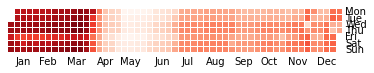

In [20]:
calmap.yearplot(pd_flights['count'], year=2020)
plt.show()

(<Figure size 1440x720 with 6 Axes>,
 array([<AxesSubplot:ylabel='2017'>, <AxesSubplot:ylabel='2018'>,
        <AxesSubplot:ylabel='2019'>, <AxesSubplot:ylabel='2020'>,
        <AxesSubplot:ylabel='2021'>, <AxesSubplot:ylabel='2022'>],
       dtype=object))

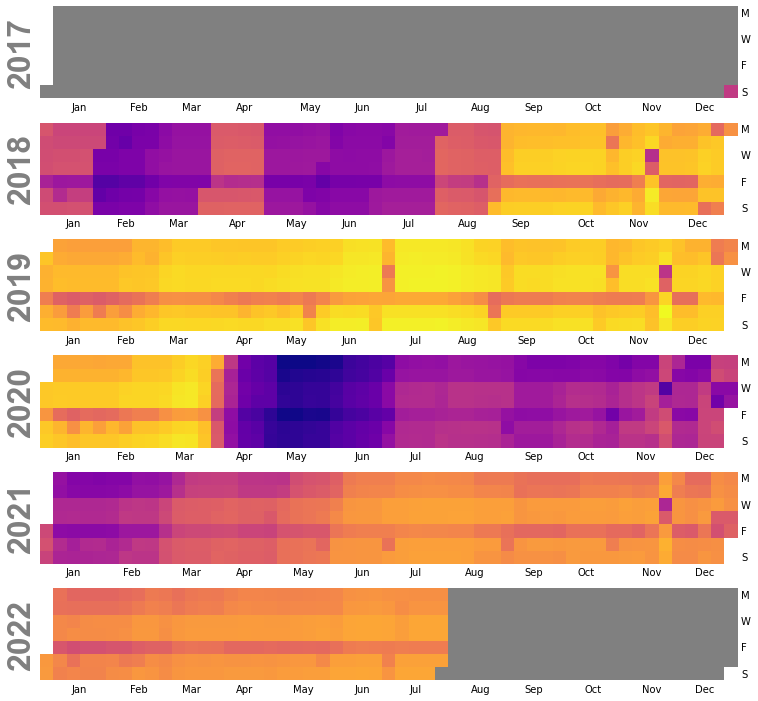

In [21]:
calmap.calendarplot(events, monthticks=3, daylabels='MTWTFSS',
                    dayticks=[0, 2, 4, 6], cmap='plasma',
                    fillcolor='grey', linewidth=0,
                    fig_kws=dict(figsize=(20, 10)))

### Boolean handling

In [22]:
[item[0] for item in data.dtypes if item[1] == 'boolean']

['Cancelled', 'Diverted']

In [23]:
data.groupBy('Cancelled').count().orderBy('count').collect()

[Row(Cancelled=True, count=777267), Row(Cancelled=False, count=28416515)]

In [24]:
data.groupBy('Diverted').count().orderBy('count').collect()

[Row(Diverted=True, count=68349), Row(Diverted=False, count=29125433)]

### String handling

In [25]:
str_columns = [item[0] for item in data.dtypes if item[1] == 'string']

In [26]:
data.select(str_columns).show(5)

+-----------------+------+----+-------------------------+---------------------------------------+---------------------------+-----------------+---------------------------+-----------+--------------+-----------+---------------+------------+---------+-------------+----------+----------+
|          Airline|Origin|Dest|Marketing_Airline_Network|Operated_or_Branded_Code_Share_Partners|IATA_Code_Marketing_Airline|Operating_Airline|IATA_Code_Operating_Airline|Tail_Number|OriginCityName|OriginState|OriginStateName|DestCityName|DestState|DestStateName|DepTimeBlk|ArrTimeBlk|
+-----------------+------+----+-------------------------+---------------------------------------+---------------------------+-----------------+---------------------------+-----------+--------------+-----------+---------------+------------+---------+-------------+----------+----------+
|Endeavor Air Inc.|   ABY| ATL|                       DL|                           DL_CODESHARE|                         DL|               9E

In [27]:
data = data.drop(data.__index_level_0__)

## Null values handling

In [28]:
null_count = data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns])

In [29]:
null_values = null_count.collect()[0].asDict()

22/12/08 09:11:01 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [30]:
only_nulls = null_count.select([key for key in null_values if null_values[key] != 0])
only_nulls.show()

+-------+---------------+--------+-------+---------------+-------+--------------+-----------------+-----------+--------+--------------------+-------+---------+--------+------+--------+--------+------------------+------------------+
|DepTime|DepDelayMinutes|DepDelay|ArrTime|ArrDelayMinutes|AirTime|CRSElapsedTime|ActualElapsedTime|Tail_Number|DepDel15|DepartureDelayGroups|TaxiOut|WheelsOff|WheelsOn|TaxiIn|ArrDelay|ArrDel15|ArrivalDelayGroups|DivAirportLandings|
+-------+---------------+--------+-------+---------------+-------+--------------+-----------------+-----------+--------+--------------------+-------+---------+--------+------+--------+--------+------------------+------------------+
| 761652|         763084|  763084| 786177|         846183| 852561|            22|           845637|     267613|  763084|              763084| 780561|   780551|  793133|793143|  846183|  846183|            846183|                90|
+-------+---------------+--------+-------+---------------+-------+------

In [31]:
# cols_to_delete = only_nulls.columns

In [32]:
# data = data.drop(*cols_to_delete)

In [33]:
# data.printSchema()

# Top 10 airlines with most market share

In [34]:
airlines_mkt_share = data.groupBy('Airline').count().sort(desc("count")).limit(10)
airlines_mkt_share.show()

+--------------------+-------+
|             Airline|  count|
+--------------------+-------+
|Southwest Airline...|5474339|
|Delta Air Lines Inc.|3294917|
|SkyWest Airlines ...|3159683|
|American Airlines...|3134117|
|United Air Lines ...|2354538|
|   Republic Airlines|1283704|
|     JetBlue Airways|1106079|
|           Envoy Air|1072778|
|   Endeavor Air Inc.| 998224|
|         Comair Inc.| 957220|
+--------------------+-------+



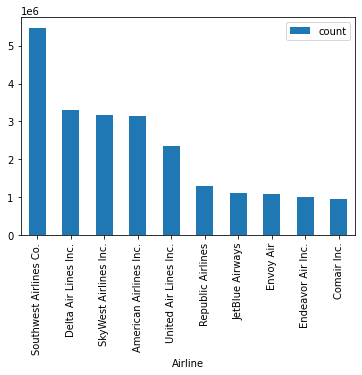

In [35]:
airlines_mkt_share.toPandas().plot(kind='bar', x="Airline", y="count")
None

In [36]:
data.select('Airline').distinct().count()

28

# Top 10 airlines with most delays

In [37]:
flights_delays = data.select('Airline', 'DepDelay')
flights_delays.first()

Row(Airline='Endeavor Air Inc.', DepDelay=-5.0)

In [38]:
df_f_delays = flights_delays.groupBy('Airline').sum().orderBy(desc('sum(DepDelay)'))
df_f_delays = df_f_delays.toPandas()
df_f_delays.head()

,Airline,sum(DepDelay)
0,Southwest Airlines Co.,53592624.0
1,American Airlines Inc.,32046403.0
2,SkyWest Airlines Inc.,30010080.0
3,United Air Lines Inc.,23529263.0
4,Delta Air Lines Inc.,21712100.0


<Figure size 2400x1600 with 0 Axes>

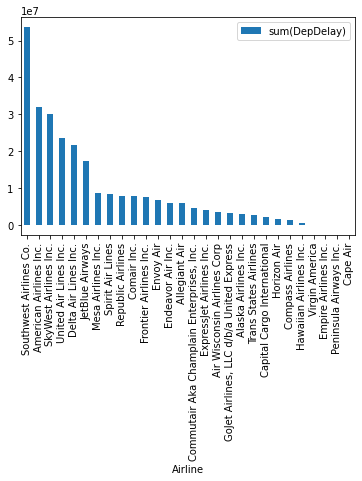

In [39]:
plt.figure(dpi=400)
df_f_delays.plot(x='Airline', y='sum(DepDelay)', kind='bar')
# plt.xticks(rotation = 45)
None

# when a flight is cancelled?

In [85]:
data_no_na = data.select('DepDelay', 'cancelled', 'FlightDate').dropna(subset='cancelled')

In [86]:
cancelled_flights = data_no_na.filter(col('cancelled') == True)
cancelled_flights.agg({"DepDelay": "avg"}).collect(), cancelled_flights.agg({"DepDelay": "std"}).collect()

([Row(avg(DepDelay)=59.22836035564853)],
 [Row(stddev(DepDelay)=111.14356252096398)])

In [87]:
successful_flights = data_no_na.filter(col('cancelled') == False)
successful_flights.agg({"DepDelay": "avg"}).collect(), successful_flights.agg({"DepDelay": "std"}).collect()

([Row(avg(DepDelay)=9.279993680891792)],
 [Row(stddev(DepDelay)=47.20826594772228)])

In [88]:
cancelled_flights.count(), successful_flights.count()

(777267, 28416515)

In [89]:
df_cancelled = cancelled_flights.toPandas()

In [90]:
df_successful = successful_flights.toPandas()

In [91]:
df_cancelled.shape, df_cancelled.dropna().shape

((777267, 3), (15296, 3))

In [92]:
df_successful.shape, df_successful.dropna().shape

((28416515, 3), (28415402, 3))

In [93]:
df_cancelled = df_cancelled.dropna()
df_successful = df_successful.dropna()

In [94]:
df_cancelled.sort_values('DepDelay', ascending=False)

,DepDelay,cancelled,FlightDate
37984,1479.0,True,2018-02-19 18:00:00
590054,1477.0,True,2021-08-06 19:00:00
87896,1459.0,True,2018-09-21 19:00:00
395539,1444.0,True,2020-07-31 19:00:00
125180,1361.0,True,2019-08-03 19:00:00
...,...,...,...
405647,-23.0,True,2020-11-29 18:00:00
244457,-23.0,True,2020-09-10 19:00:00
49325,-24.0,True,2018-04-24 19:00:00
47531,-24.0,True,2018-03-02 18:00:00


In [95]:
df_cancelled.describe()

,DepDelay
count,15296.000000
mean,59.228360
std,111.143563
min,-26.000000
25%,-3.000000
50%,16.000000
75%,83.000000
max,1479.000000


In [96]:
# Total count, q3 count
q3_cancelled = df_cancelled['DepDelay'][df_cancelled['DepDelay'] < 84]
df_cancelled['DepDelay'].shape[0], q3_cancelled.shape[0]

(15296, 11478)

<AxesSubplot:ylabel='Frequency'>

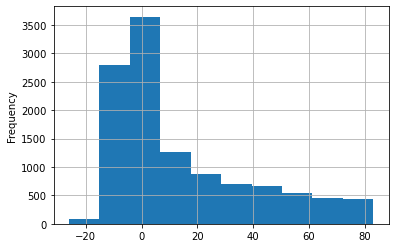

In [97]:
q3_cancelled.plot.hist(grid=True)

In [98]:
df_successful['DepDelay'].describe()

count    2.841540e+07
mean     9.279994e+00
std      4.720827e+01
min     -1.280000e+03
25%     -6.000000e+00
50%     -3.000000e+00
75%      5.000000e+00
max      7.223000e+03
Name: DepDelay, dtype: float64

In [106]:
q3_successful = df_successful['DepDelay'][(df_successful['DepDelay'] > -6) & (df_successful['DepDelay'] < 6)]
df_successful['DepDelay'].shape[0], q3_successful.shape[0]

(28415402, 13638070)

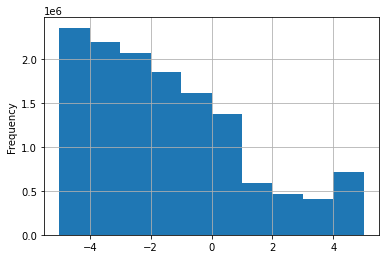

In [107]:
q3_successful.plot.hist(grid=True)
None

In [108]:
df_successful.max()

DepDelay                   7223.0
cancelled                   False
FlightDate    2022-07-30 19:00:00
dtype: object